# rasp-mibi: Recurrence And Survival Prediction via Multiplexed Ion Beam Imaging

*Multiplexed Imaging Analysis of the Tumor-Immune Microenvironment Reveals Predictors of Outcome in Triple-Negative Breast Cancer.*  
Aalok Patwa, Rikiya Yamashita, Jin Long, Michael Angelo, Leeat Keren, Daniel Rubin

# Table of Contents
* [Calculating Cell Prevalence](#calc_prevalence)
* [Calculating Protein Expression](#calc_expression)
* [Immune Composition Analysis](#comp)
* [Protein Expression Analysis](#expression)
* [Calculating Protein Co-Expression](#calc_coexpr)
* [Protein Co-Expression Analysis](#coexpr)
* [Voronoi-based Interactions](#voronoi)
* [Functional Protein Interactions Analysis](#functional)
* [Immunoregulatory Protein Interactions Analysis](#immuno)
* [Multivariate Cox Regression Analysis](#multi_cox)
* [Multivariate Random Survival Forest Analysis](#rsf)

In [4]:
import warnings

warnings.filterwarnings('ignore')

# Calculating Cell Prevalence & Immune Composition <a name="calc_prevalence"></a>
**Purpose**: calculate the proportion of cells of each cell type in each patient's image.  
**Output**: a CSV file in the intermediate_data/ folder indicating the prevalence of each cell type in each patient's image.
### NOTE
This code cannot be run without the raw MIBI data. The data is not included with this repo.  
As such, this code is simply to understand the flow of the analysis, not to be run.

In [ ]:
import os
import cv2
import numpy as np 
import PIL 
import pandas as pd
from skimage import measure
import scipy

imagepath = "rawdata/TNBCcelltypes"

#Keep track of the counts using a matrix of size n_patients X n_cells
all_info = []

#Iterate through all patients
for patient in os.listdir(imagepath):

    #Find out the recurrence label of this patient
    identifier = int(patient.split("_")[0][1:])
    
    if identifier == 30 or identifier == 22 or identifier == 38:
        continue
    
    #Read image
    image = cv2.imread(os.path.join(imagepath,patient), 0)
    
    #Connect components
    labeled, total_cells = measure.label(image, return_num=True)
    
    #Find the number of tumor cells in the image (for future reference)
    nr_tumor = measure.label((image == 4), return_num=True)[1]
    
    information = []
    information.append(identifier)
    
    information.append(total_cells)
    
    #Find the counts of all celltypes
    for celltype in range(2,17):
        selected_cell = (image == celltype)
        labeled, nr = measure.label(selected_cell, return_num=True)
        nr /= total_cells
        information.append(nr)
    
    
    all_info.append(information)
   
#Create a DataFrame of the counts with the names of the cells rather than numbers 
countdf = pd.DataFrame(all_info, columns=["ID", "Total Cells", "Endothelial", "Mesenchyme",
                                         "Tumor", "Treg", "CD4_T", "CD8_T", "CD3_T", "NK",
                                         "B", "Neutrophil", "Macrophage", "DC", "DC_Mono",
                                         "Mono_neutrophil", "Other", "Label", "Days"])

countdf.set_index("ID", inplace=True)
countdf.sort_index(ascending=True, inplace=True)
countdf.to_csv("intermediate_data/created_cellprevalence_df.csv")

display(countdf)

# Calculate Protein Expression <a name="calc_expression"></a>

**Purpose**: Calculate protein expression in each cell of each patient's image and assign positivity to each cell based on a threshold.  
**Output**: CSVs of expression levels in the intermediate_data/protein_expression/ folder and positivity assignments in intermediate_data/created_protein_positivity/  

### NOTE
This code cannot be run without the raw MIBI data. The data is not included with this repo.  
As such, this code is simply to understand the flow of the analysis, not to be run.

In [ ]:
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageDraw
from scipy.cluster.hierarchy import fcluster
import seaborn
from itertools import combinations
from itertools import product


celltype_dir = "rawdata/TNBCcelltypes/"
marker_dir = "rawdata/MIBITIFF/"
marker_frames = "rawdata/proteins_by_frame.csv"
savedir = "intermediate_data/protein_expression/"

frames = pd.read_csv(marker_frames)

columns = frames.index.values.tolist()
columns.insert(0, "Celltype")
columns.insert(0, "Column")
columns.insert(0, "Row")


for patient in os.listdir(celltype_dir):
    identifier = patient.split("_")[0][1:]
    
    marker_path = marker_dir + "p" + identifier + ".tif"
    combined_im = create_multimarker_image(marker_path)
    cv2_im = cv2.imread(os.path.join(celltype_dir, patient), cv2.IMREAD_GRAYSCALE)

    labeled, nr_objects = skimage.measure.label(cv2_im, return_num=True)
    props = skimage.measure.regionprops(labeled)
    
    all_cells = []
    for cell in range(nr_objects):
        centroid_x = int(props[cell].centroid[0])
        centroid_y = int(props[cell].centroid[1])
        
        celltype = cv2_im[centroid_x, centroid_y]

        binary_mask = (labeled == cell)
        biom_expression = combined_im[binary_mask]
        size = biom_expression.shape[0]
        expression_vector = np.sum(biom_expression, axis=0) / size
        expression_vector = expression_vector.tolist()
        expression_vector.insert(0, celltype)
        expression_vector.insert(0, centroid_y)
        expression_vector.insert(0, centroid_x)
        all_cells.append(expression_vector)
    
    dataframe = pd.DataFrame(all_cells, columns=columns)
    dataframe.to_csv(savedir + identifier + ".csv", index=False)

### Assign cells as "positive" or negative for each protein based on their expression level

In [ ]:
#Calculate the expression levels in the background (interstitial space)
celltype_dir = "rawdata/TNBCcelltypes/"
marker_dir = "rawdata/MIBITIFF/"

expression_vector = np.zeros(44)
total_pixels = 0

for patient in os.listdir(celltype_dir):
    identifier = patient.split("_")[0][1:]
    if identifier == "30" or identifier == "22" or identifier == "38":
        continue
    
    marker_path = marker_dir + "p" + identifier + ".tif"
    combined_im = create_multimarker_image(marker_path)
    cv2_im = cv2.imread(os.path.join(celltype_dir, patient), cv2.IMREAD_GRAYSCALE)
    dim = cv2_im.shape[0]

    #The TIFFs have a 29-pixel black border surrounding the image which is not a part of the sample. Exclude it.
    cells_only = cv2_im[29:dim-29, 29:dim-29]
    background_mask = (cells_only == 0)
    combined_im = combined_im[29:dim-29, 29:dim-29]
    
    #Extract just one cell
    selection = combined_im[background_mask]
    size = selection.shape[0]
    total_pixels += size
    expression_vector += np.sum(biom_expression, axis=0)

final_vector = expression_vector / total_pixels



#Binarize the matrices according to the threshold calculated across all the images.

expressiondir = "intermediate_data/protein_expression/"
savedir = "intermediate_data/created_protein_positivity/"

threshold = final_vector
for patient in os.listdir(expressiondir):
    patient_glcm = pd.read_csv(expressiondir + patient, index_col="Unnamed: 0")
    for column in range(len(patient_glcm.columns[3:])):
        col_threshold = threshold[column]
        patient_glcm[patient_glcm.columns[3+column]] = (patient_glcm[patient_glcm.columns[3+column]] > col_threshold).astype("int32")
    patient_glcm.to_csv(savedir + patient, index=False)

# Immune Composition (runnable) <a name="comp"></a>
**Purpose**: determine whether immune composition is associated with recurrence or survival. 
**Ouput**: two results CSVs in results/.

### Recurrence

In [5]:
import os
import numpy as np 
import pandas as pd
from lifelines import CoxPHFitter
from statsmodels.stats.multitest import multipletests


cellprevalence_path = "intermediate_data/cellprevalence_df.csv"

cellprevalence_df = pd.read_csv(cellprevalence_path, index_col="ID")

#Get a list of all the cell types to test
each_celltype = cellprevalence_df.columns[:15]

univariate_results = []

for celltype in each_celltype:
    
    this_cell = cellprevalence_df[[celltype, "Recurrence_time", "Recurrence"]]
    #Perform univariate Cox regression for this cell type
    cox = CoxPHFitter()
    cox.fit(this_cell, duration_col="Recurrence_time", event_col="Recurrence")
    summary_df = cox.summary
    coefficients = summary_df["coef"].values[0]
    hazards = cox.hazard_ratios_[0]
    p_values = summary_df["p"].values[0]
    
    univariate_results.append([celltype, coefficients, hazards, p_values])

univariate_results_df = pd.DataFrame(univariate_results, columns=["Celltype", "Coef", "HR", "P"])
univariate_results_df.sort_values(by="P", ascending=True, inplace=True)

p_values = univariate_results_df["P"]

corrected = multipletests(p_values, method="fdr_bh")[1]

univariate_results_df["BH-Corrected FDR"] = corrected

#univariate_results_df.to_csv("results/immune_composition_recurrence.csv", index=False)

display(univariate_results_df)

,Celltype,Coef,HR,P,BH-Corrected FDR
13,Mono_neutrophil,-37.200743,6.981080e-17,0.092788,0.646790
5,CD8_T,-7.229850,7.246292e-04,0.153589,0.646790
10,Macrophage,-5.280177,5.091531e-03,0.182385,0.646790
1,Mesenchyme,3.697473,4.034521e+01,0.182879,0.646790
4,CD4_T,-6.960764,9.483722e-04,0.243878,0.646790
2,Tumor,1.066524,2.905264e+00,0.286169,0.646790
7,NK,-86.666694,2.296852e-38,0.328973,0.646790
12,DC_Mono,-11.849144,7.144669e-06,0.344955,0.646790
0,Endothelial,10.323364,3.043546e+04,0.460475,0.767458
8,B,-1.255166,2.850286e-01,0.680366,0.898637


### Survival

In [6]:
cellprevalence_path = "intermediate_data/cellprevalence_df.csv"

cellprevalence_df = pd.read_csv(cellprevalence_path, index_col="ID")

#Get a list of all the cell types to test
each_celltype = cellprevalence_df.columns[:15]

univariate_results = []

for celltype in each_celltype:
    
    this_cell = cellprevalence_df[[celltype, "Survival_time", "Survival"]]
    #Perform univariate Cox regression for this cell type
    cox = CoxPHFitter()
    cox.fit(this_cell, duration_col="Survival_time", event_col="Survival")
    summary_df = cox.summary
    coefficients = summary_df["coef"].values[0]
    hazards = cox.hazard_ratios_[0]
    p_values = summary_df["p"].values[0]
    
    univariate_results.append([celltype, coefficients, hazards, p_values])

univariate_results_df = pd.DataFrame(univariate_results, columns=["Celltype", "Coef", "HR", "P"])
univariate_results_df.sort_values(by="P", ascending=True, inplace=True)

p_values = univariate_results_df["P"]

corrected = multipletests(p_values, method="fdr_bh")[1]

univariate_results_df["BH-Corrected FDR"] = corrected

#univariate_results_df.to_csv("results/immune_composition_survival.csv", index=False)

display(univariate_results_df)

,Celltype,Coef,HR,P,BH-Corrected FDR
12,DC_Mono,-29.226926,2.027250e-13,0.076484,0.434451
2,Tumor,1.822173,6.185285e+00,0.099043,0.434451
13,Mono_neutrophil,-33.140549,4.048016e-15,0.121261,0.434451
14,Other,-15.852785,1.303836e-07,0.124097,0.434451
10,Macrophage,-6.567408,1.405435e-03,0.144817,0.434451
1,Mesenchyme,-4.696909,9.123430e-03,0.308135,0.646003
6,CD3_T,-16.861273,4.756004e-08,0.315371,0.646003
11,DC,4.834488,1.257741e+02,0.409839,0.646003
9,Neutrophil,-11.851855,7.125327e-06,0.428513,0.646003
7,NK,35.735941,3.310717e+15,0.430669,0.646003


# Protein Expression (runnable) <a name="expression"></a>
**Purpose**: determine whether the expression of functional proteins is associated with recurrence or survival.  
**Output**: two results CSVs in results/.

### Recurrence

In [7]:
import os
import numpy as np 
import pandas as pd
from lifelines import CoxPHFitter
from statsmodels.stats.multitest import multipletests

expression_path = "intermediate_data/proteinexpression_df.csv"

proteinexpression_df = pd.read_csv(expression_path, index_col="ID")

#indices of the proteins considered to be "functional" proteins, and the clinical information
functional_protein_indices = [2,6,14,16,22,23,24,25,26,27,28,29,30,31,35,37,38,39, 44, 45, 46, 47]

#slice the functional proteins only
functional_df = proteinexpression_df.iloc[:, functional_protein_indices]

#Leave out the clinical data to iterate over the proteins
proteins = functional_df.columns[:-4]

univariate_results = []

for protein in proteins:
    this_protein = functional_df[[protein, "Recurrence_time", "Recurrence"]]
    #Fit the Cox PH model and extract information
    cox = CoxPHFitter()
    cox.fit(this_protein, duration_col="Recurrence_time", event_col="Recurrence")
    summary_df = cox.summary
    coefficients = summary_df["coef"].values[0]
    hazards = cox.hazard_ratios_[0]
    p_values = summary_df["p"].values[0]
    
    univariate_results.append([protein, coefficients, hazards, p_values])

univariate_results_df = pd.DataFrame(univariate_results, columns=["Protein", "Coef", "HR", "P"])
univariate_results_df.sort_values(by="P", ascending=True, inplace=True)

p_values = univariate_results_df["P"]

corrected = multipletests(p_values, method="fdr_bh")[1]

univariate_results_df["BH-Corrected FDR"] = corrected

#univariate_results_df.to_csv("results/protein_expression_recurrence.csv", index=False)

display(univariate_results_df)

,Protein,Coef,HR,P,BH-Corrected FDR
2,CD45RO,-1.925886,1.457466e-01,0.050833,0.312021
16,PD1,-11.183605,1.390023e-05,0.062878,0.312021
1,CD138,1.761315,5.820085e+00,0.069156,0.312021
9,IDO,-6.733982,1.189786e-03,0.083950,0.312021
8,HLA_Class_1,-5.311248,4.935762e-03,0.103791,0.312021
7,HLA-DR,-1.333538,2.635432e-01,0.119571,0.312021
13,Lag3,-23.222733,8.212877e-11,0.121342,0.312021
14,p53,-2.250886,1.053059e-01,0.211520,0.475920
6,H3K9ac,8.592960,5.393556e+03,0.331445,0.660644
5,H3K27me3,72.421874,2.834134e+31,0.367024,0.660644


### Survival

In [8]:
univariate_results = []

for protein in proteins:
    this_protein = functional_df[[protein, "Survival_time", "Survival"]]
    #Fit the Cox PH model and extract information
    cox = CoxPHFitter()
    cox.fit(this_protein, duration_col="Survival_time", event_col="Survival")
    summary_df = cox.summary
    coefficients = summary_df["coef"].values[0]
    hazards = cox.hazard_ratios_[0]
    p_values = summary_df["p"].values[0]
    
    univariate_results.append([protein, coefficients, hazards, p_values])

univariate_results_df = pd.DataFrame(univariate_results, columns=["Protein", "Coef", "HR", "P"])
univariate_results_df.sort_values(by="P", ascending=True, inplace=True)

p_values = univariate_results_df["P"]

corrected = multipletests(p_values, method="fdr_bh")[1]

univariate_results_df["BH-Corrected FDR"] = corrected

#univariate_results_df.to_csv("results/protein_expression_survival.csv", index=False)

display(univariate_results_df)

,Protein,Coef,HR,P,BH-Corrected FDR
11,Keratin6,2.490308,1.206499e+01,0.034000,0.373211
7,HLA-DR,-1.783788,1.680006e-01,0.045303,0.373211
13,Lag3,-33.601928,2.551927e-15,0.072979,0.373211
10,Keratin17,2.037864,7.674198e+00,0.096409,0.373211
8,HLA_Class_1,-5.502391,4.077010e-03,0.109218,0.373211
5,H3K27me3,-7.266533,6.985293e-04,0.145941,0.373211
9,IDO,-4.923867,7.270958e-03,0.163973,0.373211
1,CD138,1.361169,3.900750e+00,0.174841,0.373211
16,PD1,-6.858920,1.050047e-03,0.186605,0.373211
2,CD45RO,-1.147879,3.173091e-01,0.240664,0.433195


# Calculate Protein Co-Expression (runnable) <a name="calc_coexpr"></a>

**Purpose**: Calculate instances of co-expression between proteins.  
**Output**: intermediate_data/created_coexpression_matrices/. The reader can compare this output to coexpression_matrices/ to ensure reproducibility.  
**Estimated time**: 10 minutes. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn
from itertools import combinations
from itertools import product

binary_infopath = "intermediate_data/protein_positivity/"
biomarker_frames = pd.read_csv("rawdata/proteins_by_frame.csv")

biom_columns = biomarker_frames["Biomarker"].values

for patient in os.listdir(binary_infopath):
    print (patient)
    com = np.zeros((44,44))
    
    infodf = pd.read_csv(binary_infopath + patient)
        
    n_cells = len(infodf.index)
    
    for cell in range(n_cells):
        this_cell = infodf.iloc[[cell]]
        pos_columns = []
        for column in this_cell.columns[3:]:
            if this_cell[column].values[0] == 1:
                pos_columns.append(int(column))
        combs = combinations(pos_columns, 2)
        for combination in combs:
            com[combination[0], combination[1]] += 1
            com[combination[1], combination[0]] += 1
    com_df = pd.DataFrame(com, columns=biom_columns)
    com_df.set_index(pd.Index(biom_columns), inplace=True)
    com_df.to_csv("intermediate_data/created_coexpression_matrices/" + patient)

# Protein Co-Expression (runnable) <a name="coexpr"></a>

**Purpose**: determine whether protein co-expression patterns are predictors of recurrence and survival.  
**Output**: two KM curves with log-rank test p-value in results/.

### Recurrence

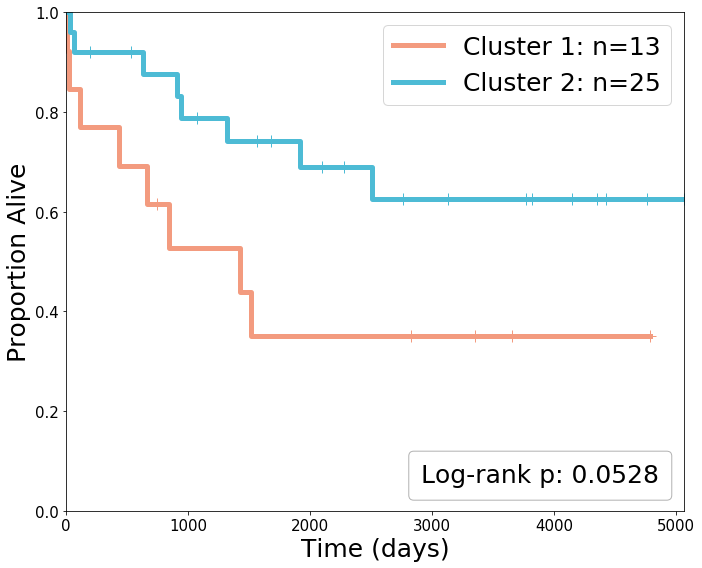

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.cluster.hierarchy import fcluster
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn


#Path to the clinical data about recurrence. 
clinical_path = "rawdata/clinical_data.csv"
clinical_df = pd.read_csv(clinical_path, index_col=["ID"])

#Path to interaction matrices
matrices_path = "intermediate_data/coexpression_matrices/"

# Out of all proteins, only include the functional proteins
markers_to_include = [2,6,14,16,22,23,24,25,26,27,28,29,30,31,35,37,38,39]

columns = []
feature_list = []

#Iterate over all of the co-occurrence matrices in this certain radius. 
for patient_index in range(len(os.listdir(matrices_path))):
    patient_glcm = os.listdir(matrices_path)[patient_index]

    #Skip over the pesky .DS_Store file that shows up in Mac file systems.
    if (patient_glcm[0] == "."):
        continue

    #Find the internal_ID of the current patient. 
    identifier = patient_glcm.split(".")[0]

    #Read the co-occurrence matrix of the current patient and cast to a numpy array excluding the first col.
    current_patient_glcm = pd.read_csv(os.path.join(matrices_path, patient_glcm), index_col="Unnamed: 0")
    current_patient_glcm.set_index(current_patient_glcm.columns, inplace=True)

    #feature_name = current_patient_glcm.columns[chosen_feature]
    np_glcm = current_patient_glcm.to_numpy()    

    patient_features = []

    #Flatten the co-occurrence matrix into a feature vector.
    #Cannot simply run np.flatten because the matrix is symmetrical - I only want the top-right triangle
    #But, we don't want to include the diagonal
    for row in range(np_glcm.shape[0]):
        for column in range(row+1, np_glcm.shape[1]):
            if row in markers_to_include and column in markers_to_include:
                if patient_index == 0:
                    feature_name = current_patient_glcm.index[row] + " " + current_patient_glcm.columns[column]
                    columns.append(feature_name)
                patient_features.append(np_glcm[row][column])

    #Find the recurrence outcome of this current patient and how long it took for them to recur
    #Add these values to the feature list for eventual use in the Kaplan-Meier plot.
    try:
        patient_features.append(clinical_df.at[int(identifier), "Recurrence"])
    except KeyError:
        continue
    patient_features.append(clinical_df.at[int(identifier), "Recurrence_time"])
    patient_features.append(int(identifier))
    feature_list.append(patient_features)

#Determine the names of the columns in the DataFrame for easier future access.
columns.append("Recurrence")
columns.append("Recurrence_time")
columns.append("ID")

#Create a dataframe using the features, the recurrence events, and the time taken to recur.

features_df = pd.DataFrame(feature_list, columns=columns)

#Obtain a versino of this dataframe with only the features.
data_only = features_df.drop(columns=["Recurrence_time", "Recurrence", "ID"])
data_only["Duplicate"] = features_df[feature_name]
data_only.set_index(features_df["ID"], inplace=True)

#Create the dendrogram.
clustergram = seaborn.clustermap(data_only, method="weighted",
                            metric="braycurtis", standard_scale = 1, cmap="viridis", figsize=(10,8), cbar_pos=None)

plt.close()

#Number of clusters to take from the dendrogram
k = 2

#Use scipy fcluster to find clusters from the clustered dendrograms.
clusters = list(fcluster(clustergram.dendrogram_row.linkage, k, criterion='maxclust'))

unique_clusters = len(np.unique(np.array(clusters)))

if (unique_clusters < 2):
    print ("Not able to find more than one cluster. ") #If there was no clustering, this method failed.

#Create a new column in the DataFrame that includes what cluster each patient falls into
features_df["clust"] = clusters

first_cluster_count = clusters.count(1)
second_cluster_count = clusters.count(2)

#Define the KaplanMeierFitter
kmf = KaplanMeierFitter()

#T = Time, E=Event. These are the two parameters that go into Kaplan-Meier curves. 
T = features_df["Recurrence_time"]
E = features_df["Recurrence"]

group1 = (features_df["clust"] == 1)
group2 = (features_df["clust"] == 2)

T1 = T[group1]
E1 = E[group1]
T2 = T[group2]
E2 = E[group2]

color_clust1 = "#F39B7FFF"
color_clust2 = "#4DBBD5FF"

# Just for visualization purposes, make the worse-outcome cluster orange and the other blue
if E1.mean() < E2.mean():
    T1 = T[group2]
    E1 = E[group2]
    T2 = T[group1]
    E2 = E[group1]

    features_df["clust"][group1] = 2
    features_df["clust"][group2] = 1

first_cluster_count = len(T1.index)
second_cluster_count = len(T2.index)

results_first = logrank_test(T1,T2, event_observed_A=E1, event_observed_B=E2)

p1 = round(results_first.p_value, 4)

plt.figure(figsize=(10,8))
kmf.fit(T1, E1, label='Cluster 1: n=' + str(first_cluster_count))
ax = kmf.plot(ci_show=False, show_censors=True, color=color_clust1, lw=5)

kmf.fit(T2, E2, label='Cluster 2: n=' + str(second_cluster_count))
ax = kmf.plot(ax=ax, ci_show=False, show_censors=True, color=color_clust2, lw=5)
plt.annotate("Log-rank p: " + str(p1), xy=(0.6, 0.15), xycoords="figure fraction", fontsize=25,
        bbox=dict(facecolor='none', edgecolor='black', alpha=0.3, boxstyle="Round, pad=0.5, rounding_size=0.2"))
plt.legend(fontsize=25)
plt.xlabel("Time (days)", fontsize=25)
plt.xticks(fontsize=15)
plt.ylabel("Proportion Alive", fontsize=25)
plt.yticks(fontsize=15)
plt.ylim(0,1)
plt.tight_layout()

#plt.savefig("results/coexpression_km_recurrence.png", dpi=300)

### Survival

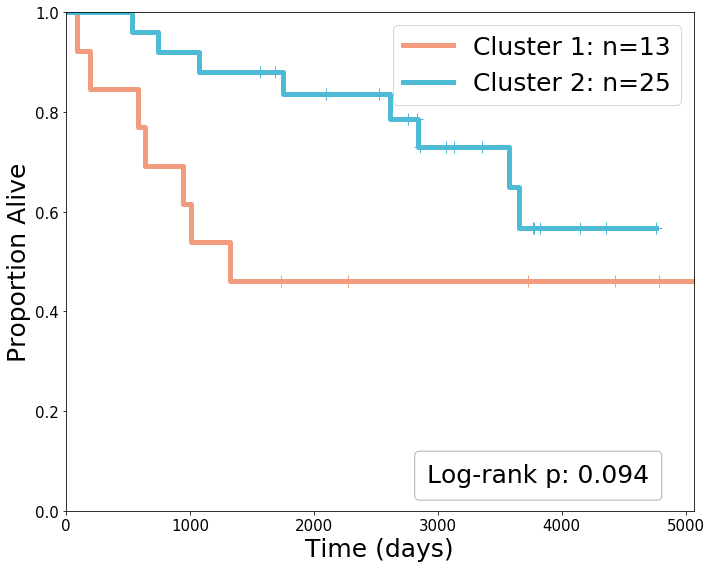

In [10]:
#Path to the clinical data. 
clinical_path = "rawdata/clinical_data.csv"
clinical_df = pd.read_csv(clinical_path, index_col=["ID"])

#Path to interaction matrices
matrices_path = "intermediate_data/coexpression_matrices/"

# Out of all proteins, only include the functional proteins
markers_to_include = [2,6,14,16,22,23,24,25,26,27,28,29,30,31,35,37,38,39]

columns = []
feature_list = []

#Iterate over all of the co-occurrence matrices in this certain radius. 
for patient_index in range(len(os.listdir(matrices_path))):
    patient_glcm = os.listdir(matrices_path)[patient_index]

    #Skip over the pesky .DS_Store file that shows up in Mac file systems.
    if (patient_glcm[0] == "."):
        continue

    #Find the internal_ID of the current patient. 
    identifier = patient_glcm.split(".")[0]

    #Read the co-occurrence matrix of the current patient and cast to a numpy array excluding the first col.
    current_patient_glcm = pd.read_csv(os.path.join(matrices_path, patient_glcm), index_col="Unnamed: 0")
    current_patient_glcm.set_index(current_patient_glcm.columns, inplace=True)

    #feature_name = current_patient_glcm.columns[chosen_feature]
    np_glcm = current_patient_glcm.to_numpy()    

    patient_features = []

    #Flatten the co-occurrence matrix into a feature vector.
    #Cannot simply run np.flatten because the matrix is symmetrical - I only want the top-right triangle
    #But, have to include the diagonal as well.
    for row in range(np_glcm.shape[0]):
        for column in range(row+1, np_glcm.shape[1]):
            if row in markers_to_include and column in markers_to_include:
                if patient_index == 0:
                    feature_name = current_patient_glcm.index[row] + " " + current_patient_glcm.columns[column]
                    columns.append(feature_name)
                patient_features.append(np_glcm[row][column])

    #Find the survival outcome of this current patient and how long it took for them to recur
    #Add these values to the feature list for eventual use in the Kaplan-Meier plot.
    try:
        patient_features.append(clinical_df.at[int(identifier), "Survival"])
    except KeyError:
        continue
    patient_features.append(clinical_df.at[int(identifier), "Survival_time"])
    patient_features.append(int(identifier))
    feature_list.append(patient_features)

#Determine the names of the columns in the DataFrame for easier future access.
columns.append("Survival")
columns.append("Survival_time")
columns.append("ID")

#Create a dataframe using the features, the survival events, and the time taken to recur.

features_df = pd.DataFrame(feature_list, columns=columns)

#Obtain a versino of this dataframe with only the features.
data_only = features_df.drop(columns=["Survival", "Survival_time", "ID"])
data_only["Duplicate"] = features_df[feature_name]
data_only.set_index(features_df["ID"], inplace=True)

#Create the dendrogram.
clustergram = seaborn.clustermap(data_only, method="weighted",
                            metric="cosine", standard_scale = 1, cmap="viridis", figsize=(10,8), cbar_pos=None)

plt.close()

#Number of clusters to take from the dendrogram
k = 2

#Use scipy fcluster to find clusters from the clustered dendrograms.
clusters = list(fcluster(clustergram.dendrogram_row.linkage, k, criterion='maxclust'))

unique_clusters = len(np.unique(np.array(clusters)))

if (unique_clusters < 2):
    print ("Not able to find more than one cluster. ") #If there was no clustering, this method failed.

#Create a new column in the DataFrame that includes what cluster each patient falls into
features_df["clust"] = clusters

first_cluster_count = clusters.count(1)
second_cluster_count = clusters.count(2)

#Define the KaplanMeierFitter
kmf = KaplanMeierFitter()

#T = Time, E=Event. These are the two parameters that go into Kaplan-Meier curves. 
T = features_df["Survival_time"]
E = features_df["Survival"]

group1 = (features_df["clust"] == 1)
group2 = (features_df["clust"] == 2)

T1 = T[group1]
E1 = E[group1]
T2 = T[group2]
E2 = E[group2]

color_clust1 = "#F39B7FFF"
color_clust2 = "#4DBBD5FF"

# Just for visualization purposes, make the worse-outcome cluster orange and the other blue
if E1.mean() < E2.mean():
    T1 = T[group2]
    E1 = E[group2]
    T2 = T[group1]
    E2 = E[group1]

features_df["clust"][group1] = 2
features_df["clust"][group2] = 1

first_cluster_count = len(T1.index)
second_cluster_count = len(T2.index)

results_first = logrank_test(T1,T2, event_observed_A=E1, event_observed_B=E2)

p1 = round(results_first.p_value, 4)

plt.figure(figsize=(10,8))
kmf.fit(T1, E1, label='Cluster 1: n=' + str(first_cluster_count))
ax = kmf.plot(ci_show=False, show_censors=True, color=color_clust1, lw=5)

kmf.fit(T2, E2, label='Cluster 2: n=' + str(second_cluster_count))
ax = kmf.plot(ax=ax, ci_show=False, show_censors=True, color=color_clust2, lw=5)
plt.annotate("Log-rank p: " + str(p1), xy=(0.6, 0.15), xycoords="figure fraction", fontsize=25,
        bbox=dict(facecolor='none', edgecolor='black', alpha=0.3, boxstyle="Round, pad=0.5, rounding_size=0.2"))
plt.legend(fontsize=25)
plt.xlabel("Time (days)", fontsize=25)
plt.xticks(fontsize=15)
plt.ylabel("Proportion Alive", fontsize=25)
plt.yticks(fontsize=15)
plt.ylim(0,1)
plt.tight_layout()

#plt.savefig("results/coexpression_km_survival.png", dpi=300)

# Voronoi-based Cell-To-Cell Interactions (runnable) <a name="voronoi"></a>

**Purpose**: calculate cell-to-cell interactions using Voronoi diagrams.  
**Output**: interaction matrices in intermediate_data/created_interaction_matrices. The reader can compare this output to interaction_matrices/ to ensure reproducibility.  
**Estimated time**: 40 minutes.

In [ ]:
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageDraw
import seaborn
from itertools import combinations
from itertools import product

def create_voronoi(centdf): #returns the Voronoi diagram object
    vor = Voronoi(np.c_[centdf.column.values, centdf.row.values])
    return vor
def plot_voronoi(vor, identifier): #Void - just plots the graph
    fig, ax = plt.subplots(figsize=(16, 16))

    fig = voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='blue', 
                      line_width=2, point_size=2)
    ax.set_xlim([0, 2048])
    ax.set_ylim([2048, 0])
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("/Users/aalokpatwa/Desktop/MIBI/voronoi/voronoi_plotsv2/" + identifier + ".png", dpi=300)
    plt.close()
    #plt.show()

def make_voronoi_dataframe(voronoi, centroiddf):
    count_skipped = 0
    number_centroids = voronoi.points.shape[0]
    information_list = []
    for centroid in range(number_centroids):
        centroid_list = []
        centroid_y = voronoi.points[centroid][0]
        centroid_x = voronoi.points[centroid][1]
        centroid_list.append(centroid)
        centroid_list.append((centroid_x, centroid_y))
        region_index = voronoi.point_region[centroid]
        centroid_list.append(region_index)
        vertices = voronoi.regions[region_index]
        if -1 in vertices:
            count_skipped += 1
            continue
        else:
            vertex_list = []
            for vertex in vertices:
                y_coord = int(round(voronoi.vertices[vertex][0]))
                x_coord = int(round(voronoi.vertices[vertex][1]))
                vertex_list.append((y_coord, x_coord))
            centroid_list.append(vertex_list)
        centroid_list.append(centroiddf.at[centroid, "celltype"])
        information_list.append(centroid_list)       
    infodf = pd.DataFrame(information_list, columns=["CentroidIndex","CentroidCoord", "RegionIndex",
                                                     "Vertices", "Celltype"])
    return infodf, count_skipped

def extract_current_mask(vertexlist):
    img = Image.new("L", (2048,2048), 0)
    ImageDraw.Draw(img).polygon(vertexlist, fill=1)
    mask = np.array(img)
    binary_mask = np.where(mask==1)
    coordinates = list(zip(binary_mask[0], binary_mask[1]))
    return coordinates, len(coordinates)

def expression_within_cell(biomarker_image, pixellist, size):
    total_vector = np.zeros(44)
    for pixel in pixellist:
        expression_vector = biomarker_image[pixel[0], pixel[1]]
        total_vector += expression_vector
    total_vector = total_vector / size
    return total_vector

def create_multimarker_image(imagepath):
    biomarker_pil = Image.open(imagepath)
    n_frames = biomarker_pil.n_frames
    
    first_level = np.array(biomarker_pil, dtype="uint8")
    first_level = np.reshape(first_level, (2048,2048,1))
        
    combined_image = first_level
    
    for frame in range(1, n_frames):
        biomarker_pil.seek(frame)
        current_level = np.array(biomarker_pil, dtype="uint8").reshape((2048,2048,1))
        combined_image = np.concatenate((combined_image, current_level), axis=2)
    return combined_image

def create_neighbor_matrix(voronoi, voronoi_df):
    number_regions = len(voronoi_df.index)
    adjacency_list = []
    for region in range(number_regions):
        adjacency_list.append([])
    ridge_points = voronoi.ridge_points
    for edge in ridge_points:
        first_centroid = edge[0]
        second_centroid = edge[1]
        first_cell = voronoi_df[voronoi_df["CentroidIndex"] == first_centroid]
        second_cell = voronoi_df[voronoi_df["CentroidIndex"] == second_centroid]
        if (first_cell.empty or second_cell.empty):
            continue
        first_index = int(first_cell.index[0])
        second_index = int(second_cell.index[0])
        adjacency_list[first_index].append(second_centroid)
        adjacency_list[second_index].append(first_centroid)
    new_df = voronoi_df.copy()
    new_df["Adjacency"] = adjacency_list
    return new_df


#-------------------------------------------------------
# Calculate interactions of each type per image

binary_infopath = "intermediate_data/protein_positivity/"
centroid_path = "intermediate_data/centroids/"
biomarker_frames = pd.read_csv("rawdata/proteins_by_frame.csv")

biom_columns = biomarker_frames["Biomarker"].values

for patient in os.listdir(binary_infopath):
    print (patient)
    if patient[0] == ".":
        continue
    com = np.zeros((44,44))
    centroid_df = pd.read_csv(centroid_path + patient)
    biom_df = pd.read_csv(binary_infopath + patient)
    vor = create_voronoi(centroid_df)
    edges = vor.ridge_points
    # Iterate through the ridge points because they define a certain combination
    for edge in edges:
        # Find the indices of the cells that the edge separates
        first_centroid = int(edge[0])
        second_centroid = int(edge[1])
        
        # Find their expression
        first_cell = biom_df.loc[[first_centroid]]
        second_cell = biom_df.loc[[second_centroid]]
    
        first_pos = []
        second_pos = []
        for column in first_cell.columns[3:]:
            if first_cell[column].values[0] == 1:
                first_pos.append(int(column))
            if second_cell[column].values[0] == 1:
                second_pos.append(int(column))
        
        #Cartesian product of the proteins that each cell in the adjacency are positive for
        combinations = product(first_pos, second_pos)
        for comb in combinations:
            first_marker = comb[0]
            second_marker = comb[1]
            com[first_marker, second_marker] += 1
            if (first_marker != second_marker):
                com[second_marker, first_marker] += 1
    com_df = pd.DataFrame(com, columns=biom_columns)
    com_df.set_index(pd.Index(biom_columns), inplace=True)
    com_df.to_csv("intermediate_data/created_interaction_matrices/" + patient)

# Functional Protein Interactions Analysis (runnable) <a name="functional"></a>

**Purpose**: determine whether interactions involving immunoregulatory proteins are predictors of recurrence and survival.  
**Output**: two KM curves with log-rank test p-value in results/.

### Recurrence

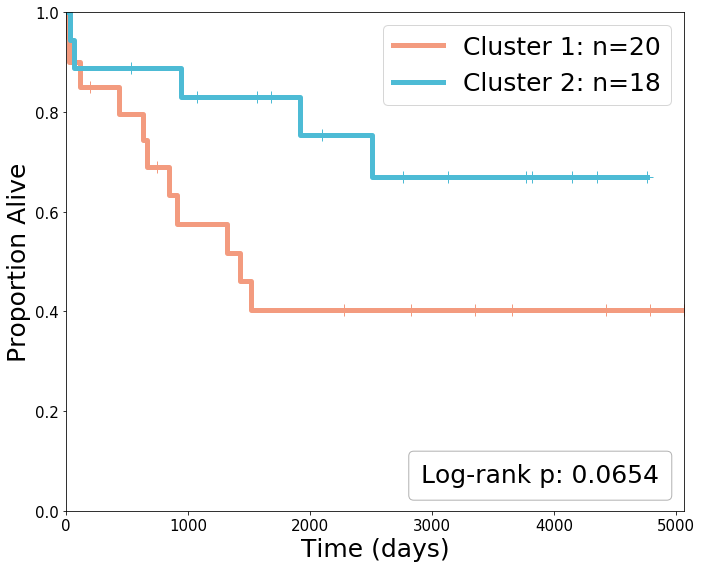

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.cluster.hierarchy import fcluster
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn

#Path to the clinical data about recurrence. 
clinical_path = "rawdata/clinical_data.csv"
clinical_df = pd.read_csv(clinical_path, index_col=["ID"])

#Path to interaction matrices
matrices_path = "intermediate_data/interaction_matrices/"

# Out of all proteins, only include the functional proteins
markers_to_include = [2,6,14,16,22,23,24,25,26,27,28,29,30,31,35,37,38,39]

columns = []
feature_list = []

#Iterate over all of the co-occurrence matrices in this certain radius. 
for patient_index in range(len(os.listdir(matrices_path))):
    patient_glcm = os.listdir(matrices_path)[patient_index]

    #Skip over the pesky .DS_Store file that shows up in Mac file systems.
    if (patient_glcm[0] == "."):
        continue

    #Find the internal_ID of the current patient. 
    identifier = patient_glcm.split(".")[0]

    #Read the co-occurrence matrix of the current patient and cast to a numpy array excluding the first col.
    current_patient_glcm = pd.read_csv(os.path.join(matrices_path, patient_glcm), index_col="Unnamed: 0")
    current_patient_glcm.set_index(current_patient_glcm.columns, inplace=True)

    #feature_name = current_patient_glcm.columns[chosen_feature]
    np_glcm = current_patient_glcm.to_numpy()    

    patient_features = []

    #Flatten the co-occurrence matrix into a feature vector.
    #Cannot simply run np.flatten because the matrix is symmetrical - I only want the top-right triangle
    #But, have to include the diagonal as well.
    for row in range(np_glcm.shape[0]):
        for column in range(row, np_glcm.shape[1]):
            if row in markers_to_include and column in markers_to_include:
                if patient_index == 0:
                    feature_name = current_patient_glcm.index[row] + " " + current_patient_glcm.columns[column]
                    columns.append(feature_name)
                patient_features.append(np_glcm[row][column])

    #Find the recurrence outcome of this current patient and how long it took for them to recur
    #Add these values to the feature list for eventual use in the Kaplan-Meier plot.
    try:
        patient_features.append(clinical_df.at[int(identifier), "Recurrence"])
    except KeyError:
        continue
    patient_features.append(clinical_df.at[int(identifier), "Recurrence_time"])
    patient_features.append(int(identifier))
    feature_list.append(patient_features)

#Determine the names of the columns in the DataFrame for easier future access.
columns.append("Recurrence")
columns.append("Recurrence_time")
columns.append("ID")

#Create a dataframe using the features, the recurrence events, and the time taken to recur.
features_df = pd.DataFrame(feature_list, columns=columns)

#Obtain a versino of this dataframe with only the features.
data_only = features_df.drop(columns=["Recurrence_time", "Recurrence", "ID"])
data_only["Duplicate"] = data_only[feature_name]
data_only.set_index(features_df["ID"], inplace=True)

#Create the dendrogram.
clustergram = seaborn.clustermap(data_only, method="complete",
                            metric="braycurtis", standard_scale = 1, cmap="viridis", figsize=(10,8), cbar_pos=None)

plt.close()

#Number of clusters to take from the dendrogram
k = 2

#Use scipy fcluster to find clusters from the clustered dendrograms.
clusters = list(fcluster(clustergram.dendrogram_row.linkage, k, criterion='maxclust'))

unique_clusters = len(np.unique(np.array(clusters)))

if (unique_clusters < 2):
    print ("Not able to find more than one cluster. ") #If there was no clustering, this method failed.

#Create a new column in the DataFrame that includes what cluster each patient falls into
features_df["clust"] = clusters

first_cluster_count = clusters.count(1)
second_cluster_count = clusters.count(2)

#Define the KaplanMeierFitter
kmf = KaplanMeierFitter()

#T = Time, E=Event. These are the two parameters that go into Kaplan-Meier curves. 
T = features_df["Recurrence_time"]
E = features_df["Recurrence"]

group1 = (features_df["clust"] == 1)
group2 = (features_df["clust"] == 2)

T1 = T[group1]
E1 = E[group1]
T2 = T[group2]
E2 = E[group2]

color_clust1 = "#F39B7FFF"
color_clust2 = "#4DBBD5FF"

# Just for visualization purposes, make the worse-outcome cluster orange and the other blue
if E1.mean() < E2.mean():
    T1 = T[group2]
    E1 = E[group2]
    T2 = T[group1]
    E2 = E[group1]

    features_df["clust"][group1] = 2
    features_df["clust"][group2] = 1

first_cluster_count = len(T1.index)
second_cluster_count = len(T2.index)

results_first = logrank_test(T1,T2, event_observed_A=E1, event_observed_B=E2)

p1 = round(results_first.p_value, 4)

plt.figure(figsize=(10,8))
kmf.fit(T1, E1, label='Cluster 1: n=' + str(first_cluster_count))
ax = kmf.plot(ci_show=False, show_censors=True, color=color_clust1, lw=5)

kmf.fit(T2, E2, label='Cluster 2: n=' + str(second_cluster_count))
ax = kmf.plot(ax=ax, ci_show=False, show_censors=True, color=color_clust2, lw=5)
plt.annotate("Log-rank p: " + str(p1), xy=(0.6, 0.15), xycoords="figure fraction", fontsize=25,
        bbox=dict(facecolor='none', edgecolor='black', alpha=0.3, boxstyle="Round, pad=0.5, rounding_size=0.2"))
plt.legend(fontsize=25)
plt.xlabel("Time (days)", fontsize=25)
plt.xticks(fontsize=15)
plt.ylabel("Proportion Alive", fontsize=25)
plt.yticks(fontsize=15)
plt.ylim(0,1)
plt.tight_layout()

#plt.savefig("results/functional_interactions_km_recurrence.png", dpi=300)

### Survival

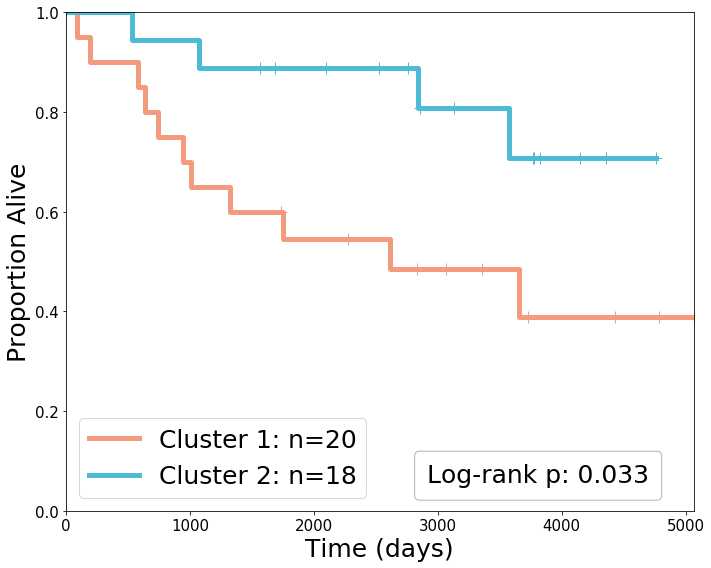

In [12]:
#Path to the clinical data. 
clinical_path = "rawdata/clinical_data.csv"
clinical_df = pd.read_csv(clinical_path, index_col=["ID"])

#Path to interaction matrices
matrices_path = "intermediate_data/interaction_matrices/"

# Out of all proteins, only include the functional proteins
markers_to_include = [2,6,14,16,22,23,24,25,26,27,28,29,30,31,35,37,38,39]

columns = []
feature_list = []

#Iterate over all of the co-occurrence matrices in this certain radius. 
for patient_index in range(len(os.listdir(matrices_path))):
    patient_glcm = os.listdir(matrices_path)[patient_index]

    #Skip over the pesky .DS_Store file that shows up in Mac file systems.
    if (patient_glcm[0] == "."):
        continue

    #Find the internal_ID of the current patient. 
    identifier = patient_glcm.split(".")[0]

    #Read the co-occurrence matrix of the current patient and cast to a numpy array excluding the first col.
    current_patient_glcm = pd.read_csv(os.path.join(matrices_path, patient_glcm), index_col="Unnamed: 0")
    current_patient_glcm.set_index(current_patient_glcm.columns, inplace=True)

    #feature_name = current_patient_glcm.columns[chosen_feature]
    np_glcm = current_patient_glcm.to_numpy()    

    patient_features = []

    #Flatten the co-occurrence matrix into a feature vector.
    #Cannot simply run np.flatten because the matrix is symmetrical - I only want the top-right triangle
    #But, have to include the diagonal as well.
    for row in range(np_glcm.shape[0]):
        for column in range(row, np_glcm.shape[1]):
            if row in markers_to_include and column in markers_to_include:
                if patient_index == 0:
                    feature_name = current_patient_glcm.index[row] + " " + current_patient_glcm.columns[column]
                    columns.append(feature_name)
                patient_features.append(np_glcm[row][column])

    #Find the survival outcome of this current patient and how long it took for them to recur
    #Add these values to the feature list for eventual use in the Kaplan-Meier plot.
    try:
        patient_features.append(clinical_df.at[int(identifier), "Survival"])
    except KeyError:
        continue
    patient_features.append(clinical_df.at[int(identifier), "Survival_time"])
    patient_features.append(int(identifier))
    feature_list.append(patient_features)

#Determine the names of the columns in the DataFrame for easier future access.
columns.append("Survival")
columns.append("Survival_time")
columns.append("ID")

#Create a dataframe using the features, the survival events, and the time taken to recur.

features_df = pd.DataFrame(feature_list, columns=columns)

#Obtain a versino of this dataframe with only the features.
data_only = features_df.drop(columns=["Survival", "Survival_time", "ID"])
data_only["Duplicate"] = data_only[feature_name]
data_only.set_index(features_df["ID"], inplace=True)

#Create the dendrogram.
clustergram = seaborn.clustermap(data_only, method="complete",
                            metric="braycurtis", standard_scale = 1, cmap="viridis", figsize=(10,8), cbar_pos=None)

plt.close()

#Number of clusters to take from the dendrogram
k = 2

#Use scipy fcluster to find clusters from the clustered dendrograms.
clusters = list(fcluster(clustergram.dendrogram_row.linkage, k, criterion='maxclust'))

unique_clusters = len(np.unique(np.array(clusters)))

if (unique_clusters < 2):
    print ("Not able to find more than one cluster. ") #If there was no clustering, this method failed.

#Create a new column in the DataFrame that includes what cluster each patient falls into
features_df["clust"] = clusters

first_cluster_count = clusters.count(1)
second_cluster_count = clusters.count(2)

#Define the KaplanMeierFitter
kmf = KaplanMeierFitter()

#T = Time, E=Event. These are the two parameters that go into Kaplan-Meier curves. 
T = features_df["Survival_time"]
E = features_df["Survival"]

group1 = (features_df["clust"] == 1)
group2 = (features_df["clust"] == 2)

T1 = T[group1]
E1 = E[group1]
T2 = T[group2]
E2 = E[group2]

color_clust1 = "#F39B7FFF"
color_clust2 = "#4DBBD5FF"

# Just for visualization purposes, make the worse-outcome cluster orange and the other blue
if E1.mean() < E2.mean():
    T1 = T[group2]
    E1 = E[group2]
    T2 = T[group1]
    E2 = E[group1]

features_df["clust"][group1] = 2
features_df["clust"][group2] = 1

first_cluster_count = len(T1.index)
second_cluster_count = len(T2.index)

results_first = logrank_test(T1,T2, event_observed_A=E1, event_observed_B=E2)

p1 = round(results_first.p_value, 4)

plt.figure(figsize=(10,8))
kmf.fit(T1, E1, label='Cluster 1: n=' + str(first_cluster_count))
ax = kmf.plot(ci_show=False, show_censors=True, color=color_clust1, lw=5)

kmf.fit(T2, E2, label='Cluster 2: n=' + str(second_cluster_count))
ax = kmf.plot(ax=ax, ci_show=False, show_censors=True, color=color_clust2, lw=5)
plt.annotate("Log-rank p: " + str(p1), xy=(0.6, 0.15), xycoords="figure fraction", fontsize=25,
        bbox=dict(facecolor='none', edgecolor='black', alpha=0.3, boxstyle="Round, pad=0.5, rounding_size=0.2"))
plt.legend(fontsize=25)
plt.xlabel("Time (days)", fontsize=25)
plt.xticks(fontsize=15)
plt.ylabel("Proportion Alive", fontsize=25)
plt.yticks(fontsize=15)
plt.ylim(0,1)
plt.tight_layout()

#plt.savefig("results/functional_interactions_km_survival.png", dpi=300)

# Immunoregulatory Protein Interactions Analysis (runnable) <a name="immuno"></a>
**Purpose**: determine whether interactions involving immunoregulatory proteins are predictors of recurrence and survival.  
**Output**: two KM curves with log-rank test p-value in results/.

### Recurrence

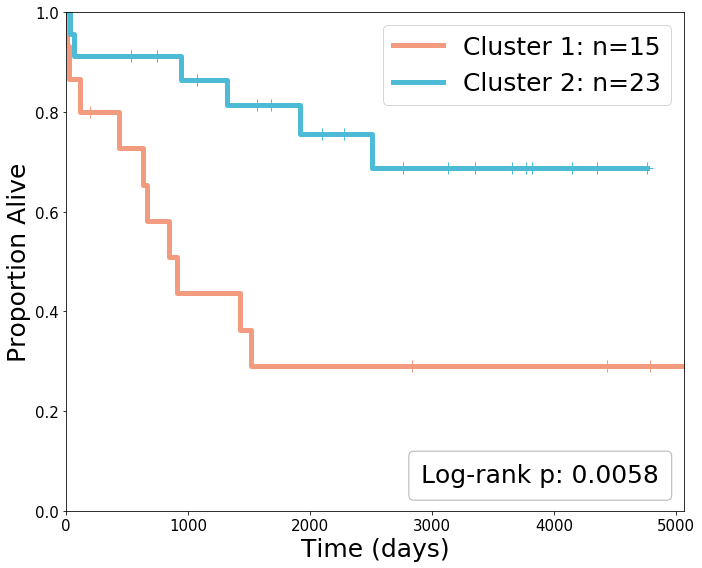

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.cluster.hierarchy import fcluster
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn


#Path to the clinical data. 
clinical_path = "rawdata/clinical_data.csv"
clinical_df = pd.read_csv(clinical_path, index_col=["ID"])

#Path to interaction matrices
matrices_path = "intermediate_data/interaction_matrices/"

# Out of all proteins, only include the functional proteins
markers_to_include = [27, 31, 37, 38]

columns = []
feature_list = []

#Iterate over all of the co-occurrence matrices in this certain radius. 
for patient_index in range(len(os.listdir(matrices_path))):
    patient_glcm = os.listdir(matrices_path)[patient_index]

    #Skip over the pesky .DS_Store file that shows up in Mac file systems.
    if (patient_glcm[0] == "."):
        continue

    #Find the internal_ID of the current patient. 
    identifier = patient_glcm.split(".")[0]

    #Read the co-occurrence matrix of the current patient and cast to a numpy array excluding the first col.
    current_patient_glcm = pd.read_csv(os.path.join(matrices_path, patient_glcm), index_col="Unnamed: 0")
    current_patient_glcm.set_index(current_patient_glcm.columns, inplace=True)

    #feature_name = current_patient_glcm.columns[chosen_feature]
    np_glcm = current_patient_glcm.to_numpy()    

    patient_features = []

    #Flatten the co-occurrence matrix into a feature vector.
    #Cannot simply run np.flatten because the matrix is symmetrical - I only want the top-right triangle
    #But, have to include the diagonal as well.
    for row in range(np_glcm.shape[0]):
        for column in range(row, np_glcm.shape[1]):
            if row in markers_to_include and column in markers_to_include:
                if patient_index == 0:
                    feature_name = current_patient_glcm.index[row] + " " + current_patient_glcm.columns[column]
                    columns.append(feature_name)
                patient_features.append(np_glcm[row][column])

    #Find the recurrence outcome of this current patient and how long it took for them to recur
    #Add these values to the feature list for eventual use in the Kaplan-Meier plot.
    try:
        patient_features.append(clinical_df.at[int(identifier), "Recurrence"])
    except KeyError:
        continue
    patient_features.append(clinical_df.at[int(identifier), "Recurrence_time"])
    patient_features.append(int(identifier))
    feature_list.append(patient_features)

#Determine the names of the columns in the DataFrame for easier future access.
columns.append("Recurrence")
columns.append("Recurrence_time")
columns.append("ID")

#Create a dataframe using the features, the recurrence events, and the time taken to recur.
features_df = pd.DataFrame(feature_list, columns=columns)

#Obtain a versino of this dataframe with only the features.
data_only = features_df.drop(columns=["Recurrence_time", "Recurrence", "ID"])
data_only.set_index(features_df["ID"], inplace=True)

#Create the dendrogram.
clustergram = seaborn.clustermap(data_only, method="weighted",
                            metric="canberra", standard_scale = 1, cmap="viridis", figsize=(10,8), cbar_pos=None)

plt.close()

#Number of clusters to take from the dendrogram
k = 2

#Use scipy fcluster to find clusters from the clustered dendrograms.
clusters = list(fcluster(clustergram.dendrogram_row.linkage, k, criterion='maxclust'))

unique_clusters = len(np.unique(np.array(clusters)))

if (unique_clusters < 2):
    print ("Not able to find more than one cluster. ") #If there was no clustering, this method failed.

#Create a new column in the DataFrame that includes what cluster each patient falls into
features_df["clust"] = clusters

first_cluster_count = clusters.count(1)
second_cluster_count = clusters.count(2)

#Define the KaplanMeierFitter
kmf = KaplanMeierFitter()

#T = Time, E=Event. These are the two parameters that go into Kaplan-Meier curves. 
T = features_df["Recurrence_time"]
E = features_df["Recurrence"]

group1 = (features_df["clust"] == 1)
group2 = (features_df["clust"] == 2)

T1 = T[group1]
E1 = E[group1]
T2 = T[group2]
E2 = E[group2]

color_clust1 = "#F39B7FFF"
color_clust2 = "#4DBBD5FF"

# Just for visualization purposes, make the worse-outcome cluster orange and the other blue
if E1.mean() < E2.mean():
    T1 = T[group2]
    E1 = E[group2]
    T2 = T[group1]
    E2 = E[group1]

    features_df["clust"][group1] = 2
    features_df["clust"][group2] = 1

first_cluster_count = len(T1.index)
second_cluster_count = len(T2.index)

results_first = logrank_test(T1,T2, event_observed_A=E1, event_observed_B=E2)

p1 = round(results_first.p_value, 4)

plt.figure(figsize=(10,8))
kmf.fit(T1, E1, label='Cluster 1: n=' + str(first_cluster_count))
ax = kmf.plot(ci_show=False, show_censors=True, color=color_clust1, lw=5)

kmf.fit(T2, E2, label='Cluster 2: n=' + str(second_cluster_count))
ax = kmf.plot(ax=ax, ci_show=False, show_censors=True, color=color_clust2, lw=5)
plt.annotate("Log-rank p: " + str(p1), xy=(0.6, 0.15), xycoords="figure fraction", fontsize=25,
        bbox=dict(facecolor='none', edgecolor='black', alpha=0.3, boxstyle="Round, pad=0.5, rounding_size=0.2"))
plt.legend(fontsize=25)
plt.xlabel("Time (days)", fontsize=25)
plt.xticks(fontsize=15)
plt.ylabel("Proportion Alive", fontsize=25)
plt.yticks(fontsize=15)
plt.ylim(0,1)
plt.tight_layout()

#plt.savefig("results/immunoregulatory_interactions_km_recurrence.png", dpi=300)

### Survival

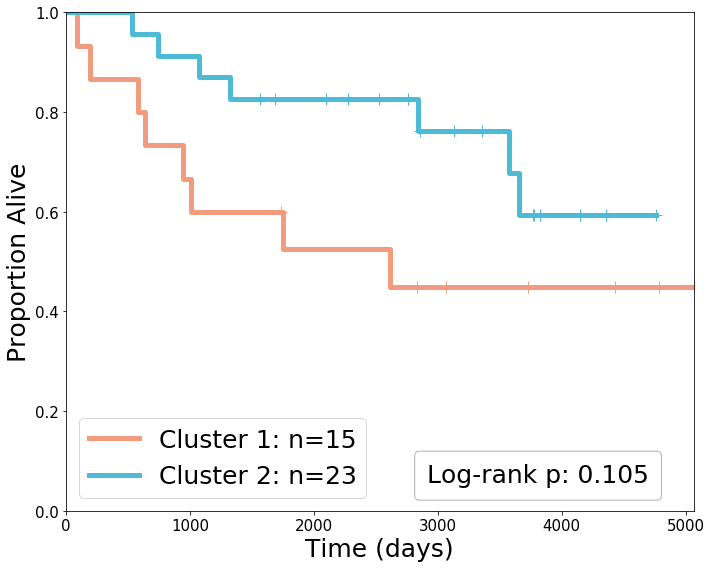

In [15]:
#Path to the clinical data. 
clinical_path = "rawdata/clinical_data.csv"
clinical_df = pd.read_csv(clinical_path, index_col=["ID"])

#Path to interaction matrices
matrices_path = "intermediate_data/interaction_matrices/"

# Out of all proteins, only include the functional proteins
markers_to_include = [27, 31, 37, 38]

columns = []
feature_list = []

#Iterate over all of the co-occurrence matrices in this certain radius. 
for patient_index in range(len(os.listdir(matrices_path))):
    patient_glcm = os.listdir(matrices_path)[patient_index]

    #Skip over the pesky .DS_Store file that shows up in Mac file systems.
    if (patient_glcm[0] == "."):
        continue

    #Find the internal_ID of the current patient. 
    identifier = patient_glcm.split(".")[0]

    #Read the co-occurrence matrix of the current patient and cast to a numpy array excluding the first col.
    current_patient_glcm = pd.read_csv(os.path.join(matrices_path, patient_glcm), index_col="Unnamed: 0")
    current_patient_glcm.set_index(current_patient_glcm.columns, inplace=True)

    #feature_name = current_patient_glcm.columns[chosen_feature]
    np_glcm = current_patient_glcm.to_numpy()    

    patient_features = []

    #Flatten the co-occurrence matrix into a feature vector.
    #Cannot simply run np.flatten because the matrix is symmetrical - I only want the top-right triangle
    #But, have to include the diagonal as well.
    for row in range(np_glcm.shape[0]):
        for column in range(row, np_glcm.shape[1]):
            if row in markers_to_include and column in markers_to_include:
                if patient_index == 0:
                    feature_name = current_patient_glcm.index[row] + " " + current_patient_glcm.columns[column]
                    columns.append(feature_name)
                patient_features.append(np_glcm[row][column])

    #Find the survival outcome of this current patient and how long it took for them to recur
    #Add these values to the feature list for eventual use in the Kaplan-Meier plot.
    try:
        patient_features.append(clinical_df.at[int(identifier), "Survival"])
    except KeyError:
        continue
    patient_features.append(clinical_df.at[int(identifier), "Survival_time"])
    patient_features.append(int(identifier))
    feature_list.append(patient_features)

#Determine the names of the columns in the DataFrame for easier future access.
columns.append("Survival")
columns.append("Survival_time")
columns.append("ID")

#Create a dataframe using the features, the survival events, and the time taken to recur.

features_df = pd.DataFrame(feature_list, columns=columns)

#Obtain a versino of this dataframe with only the features.
data_only = features_df.drop(columns=["Survival", "Survival_time", "ID"])
data_only.set_index(features_df["ID"], inplace=True)

#Create the dendrogram.
clustergram = seaborn.clustermap(data_only, method="weighted",
                            metric="canberra", standard_scale = 1, cmap="viridis", figsize=(10,8), cbar_pos=None)

plt.close()

#Number of clusters to take from the dendrogram
k = 2

#Use scipy fcluster to find clusters from the clustered dendrograms.
clusters = list(fcluster(clustergram.dendrogram_row.linkage, k, criterion='maxclust'))

unique_clusters = len(np.unique(np.array(clusters)))

if (unique_clusters < 2):
    print ("Not able to find more than one cluster. ") #If there was no clustering, this method failed.

#Create a new column in the DataFrame that includes what cluster each patient falls into
features_df["clust"] = clusters

first_cluster_count = clusters.count(1)
second_cluster_count = clusters.count(2)

#Define the KaplanMeierFitter
kmf = KaplanMeierFitter()

#T = Time, E=Event. These are the two parameters that go into Kaplan-Meier curves. 
T = features_df["Survival_time"]
E = features_df["Survival"]

group1 = (features_df["clust"] == 1)
group2 = (features_df["clust"] == 2)

T1 = T[group1]
E1 = E[group1]
T2 = T[group2]
E2 = E[group2]

color_clust1 = "#F39B7FFF"
color_clust2 = "#4DBBD5FF"

# Just for visualization purposes, make the worse-outcome cluster orange and the other blue
if E1.mean() < E2.mean():
    T1 = T[group2]
    E1 = E[group2]
    T2 = T[group1]
    E2 = E[group1]

features_df["clust"][group1] = 2
features_df["clust"][group2] = 1

first_cluster_count = len(T1.index)
second_cluster_count = len(T2.index)

results_first = logrank_test(T1,T2, event_observed_A=E1, event_observed_B=E2)

p1 = round(results_first.p_value, 4)

plt.figure(figsize=(10,8))
kmf.fit(T1, E1, label='Cluster 1: n=' + str(first_cluster_count))
ax = kmf.plot(ci_show=False, show_censors=True, color=color_clust1, lw=5)

kmf.fit(T2, E2, label='Cluster 2: n=' + str(second_cluster_count))
ax = kmf.plot(ax=ax, ci_show=False, show_censors=True, color=color_clust2, lw=5)
plt.annotate("Log-rank p: " + str(p1), xy=(0.6, 0.15), xycoords="figure fraction", fontsize=25,
        bbox=dict(facecolor='none', edgecolor='black', alpha=0.3, boxstyle="Round, pad=0.5, rounding_size=0.2"))
plt.legend(fontsize=25)
plt.xlabel("Time (days)", fontsize=25)
plt.xticks(fontsize=15)
plt.ylabel("Proportion Alive", fontsize=25)
plt.yticks(fontsize=15)
plt.ylim(0,1)
plt.tight_layout()

#plt.savefig("results/immunoregulatory_interactions_km_survival.png", dpi=300)

# Multivariate Analysis 1: Cox Regression (runnable) <a name="multi_cox"></a>
**Purpose**: perform multivariate Cox regression.  
**Demo Note**: the reader should change the type of cluster to be examined based on the options given in the comments.  
**Output**: a model summary printed to output.

In [17]:
#Imports
import numpy as np
import pandas as pd
import lifelines
import seaborn as sns

CSV_PATH = "intermediate_data/covariate_rsf_data.csv" #put path to csv summarizing cluster features, clinical variables, architecutre distinction, and clinical outcome

#Read csv summarizing cluster features, clinical variables, morphology distinction, and clinical outcome
df = pd.read_csv(CSV_PATH, index_col="ID")

#define which cluster feature to examine
#options: [coexpression_cluster, functional_proteins_cluster, immunoregulatory_protein_cluster]
#can either examine each one-at-a-time or iterate through them
cluster_choice = "immunoregulatory_protein_cluster" 

#manipulate the architecture distinction the variable which is originally dtype: str into a quantitative categorical variable
df["Architecture"] = df["Architecture"].astype("category").cat.codes

#Create two separate feature matrices for recurrence and survival
recurrence_df = df.drop(columns=["Survival", "Survival_time"])[[cluster_choice, "grade", "age", "Architecture", "Recurrence", "Recurrence_time"]]
survival_df = df.drop(columns=["Recurrence", "Recurrence_time"])[[cluster_choice, "grade", "age", "Architecture", "Survival", "Survival_time"]]

#Define and fit Cox PH Fitter for recurrence
recurrence_cph = lifelines.CoxPHFitter()
recurrence_cph.fit(recurrence_df, duration_col='Recurrence_time', event_col='Recurrence')
recurrence_summary = recurrence_cph.print_summary()

#Define and fit Cox PH Fitter for survival
survival_cph = lifelines.CoxPHFitter()
survival_cph.fit(survival_df, duration_col='Survival_time', event_col='Survival')
survival_summary = survival_cph.print_summary()

# Multivariate Analysis 2: Random Survival Forest (runnable) <a name="rsf"></a>
**Purpose**: build a random survival forest to evaluate importance and measure model accuracy.  
**Output**: an importance plot in results/ and a concordance index printed to output.  
**Estimated time**: 2 minutes.

In [ ]:
#Imports
from pysurvival.models import survival_forest
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pysurvival.models import survival_forest
from pysurvival.utils.metrics import concordance_index
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

#--------------------------------------------------------------------
#Calculating Shapley values

#Provide the path to the csv with the multivariate data
CSV_PATH = "intermediate_data/covariate_rsf_data.csv"

#Import CSV into a dataframe
data = pd.read_csv(CSV_PATH, index_col="ID")

#Manipulate the architecture feature from a string into a quantitative categorical variable
data["Architecture"] = data["Architecture"].astype("category").cat.codes

#Define the random survival forest model
rf = survival_forest.RandomSurvivalForestModel(num_trees = 200)

#Define predictors and response for inputting into the model
X = data[["functional_proteins_cluster", "immunoregulatory_protein_cluster", "coexpression_cluster", "age", "grade", "Architecture"]]
T = data["Survival_time"]
E = data["Survival"]

#Fit the RSF
fitted = rf.fit(X=X, T=T, E=E, max_depth=5)

#Train the Shap KernelExplainer and calculate Shapley values
explainer = shap.KernelExplainer(fitted.predict_risk, data=X)
shap_values = explainer.shap_values(X)

#Plot the Shapley values as a bar plot
fig = shap.summary_plot(shap_values, features=X, plot_type='bar')

#plt.savefig("results/importance_plot.png", dpi=300)

#--------------------------------------------------------------------
#Evaluating model performance

#Define a number of iterations to fit the model on different seeds
iterations = 1000

importance_array = np.zeros((6))
concordances = []


for iter in range(iterations):
    data_train, data_test = train_test_split(data, test_size=0.2, random_state=iter)
    X_train = data_train[["functional_proteins_cluster", "immunoregulatory_protein_cluster", "coexpression_cluster", 
              "age", "grade", "Architecture"]]
    T_train = data_train["Recurrence_time"]
    E_train = data_train["Recurrence"]

    X_test = data_test[["functional_proteins_cluster", "immunoregulatory_protein_cluster", "coexpression_cluster", 
              "age", "grade", "Architecture"]]
    T_test = data_test["Recurrence_time"]
    E_test = data_test["Recurrence"]

    #Fit the RSF according to the training set
    fitted = rf.fit(X=X_train, T=T_train, E=E_train, max_depth=5, seed=iter)
    concordance = concordance_index(rf, X, T, E, include_ties = True, additional_results=False)
    concordances.append(concordance)

mean_concordance = np.mean(np.array(concordances))

print ("Mean concordance index: " + str(round(mean_concordance, 4)))